In [ ]:
from google.colab import drive
import pandas as pd
# Mount your Google Drive
drive.mount('/content/drive')

# Load the dataset (adjust the file path to match your file's location in Drive)
file_path = '/content/df_merge.csv'
df = pd.read_csv(file_path)

# Display the dataset
print(df.head())


Mounted at /content/drive
   Unnamed: 0                                              title  \
0           0   Donald Trump Sends Out Embarrassing New Year’...   
1           1   Drunk Bragging Trump Staffer Started Russian ...   
2           2   Sheriff David Clarke Becomes An Internet Joke...   
3           3   Trump Is So Obsessed He Even Has Obama’s Name...   
4           4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  class  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-5-fef595b0a955>:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradSca

Epoch 1 - Training Loss: 0.7346, Validation Accuracy: 0.5050


 67%|██████▋   | 200/300 [24:50<12:03,  7.24s/it]

Epoch 2 - Training Loss: 0.6327, Validation Accuracy: 0.5050


100%|██████████| 300/300 [37:24<00:00,  7.27s/it]

Epoch 3 - Training Loss: 0.4924, Validation Accuracy: 0.4900


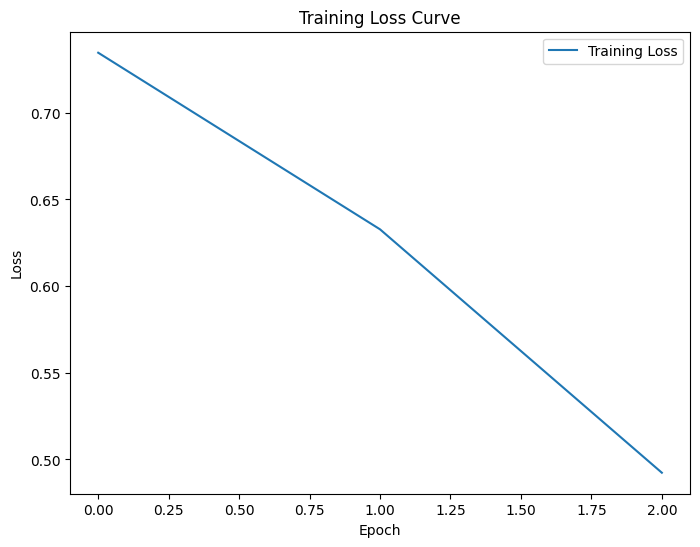

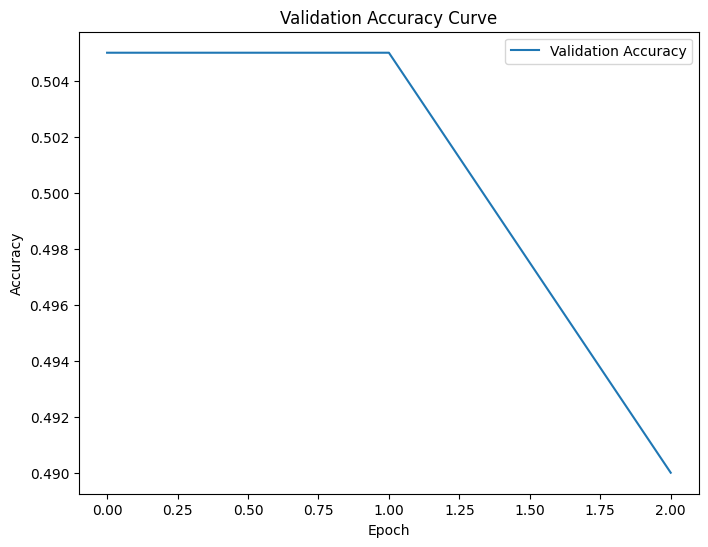

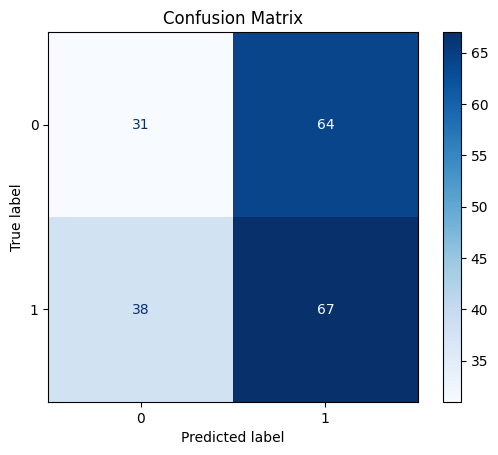

In [ ]:
# Install required libraries
!pip install transformers datasets matplotlib scikit-learn

# Import necessary libraries
import pandas as pd
import torch
from transformers import BartTokenizer, BartForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import get_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Load and reduce dataset for quick testing
df = pd.read_csv('/content/df_merge.csv')
df = df.sample(1000, random_state=42)  # Use 1000 samples for training

# Ensure the dataset has necessary columns
if 'text' not in df.columns:
    raise ValueError("Dataset must contain a 'text' column.")

if 'label' not in df.columns:
    import numpy as np
    np.random.seed(42)
    df['label'] = np.random.randint(0, 2, size=len(df))  # Binary labels: 0 or 1

# Tokenizer initialization for BART
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
        }

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Create DataLoaders
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer, max_len=64)
val_dataset = FakeNewsDataset(val_texts, val_labels, tokenizer, max_len=64)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Load the BART model
model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Mixed precision training setup
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# Training loop
epochs = 3
progress_bar = tqdm(range(num_training_steps))
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast():
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['label']
            )
            loss = outputs.loss
            total_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation step
    model.eval()
    correct = 0
    total = 0
    val_predictions = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            predictions = torch.argmax(outputs.logits, dim=-1)
            val_predictions.extend(predictions.cpu().numpy())
            val_labels_list.extend(batch['label'].cpu().numpy())
            correct += (predictions == batch['label']).sum().item()
            total += batch['label'].size(0)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plot Validation Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(val_labels_list, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Validation step
model.eval()
correct = 0
total = 0
val_predictions = []
val_labels_list = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        predictions = torch.argmax(outputs.logits, dim=-1)
        val_predictions.extend(predictions.cpu().numpy())
        val_labels_list.extend(batch['label'].cpu().numpy())
        correct += (predictions == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
val_accuracies.append(accuracy)



In [ ]:
print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Epoch 3 - Training Loss: 0.4924, Validation Accuracy: 0.4900
